In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [56]:
df_train = pd.read_csv('./data/train_2025.csv')
df_test = pd.read_csv('./data/test_2025.csv')

df_train.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,2759,58,M,1.0,83,117115,1,0,Own,85027,...,88,Broker,0,0.00,4,Medium,55066.875563,other,21515.14956,0
1,11338,37,F,0.0,76,57945,1,0,Rent,85004,...,2,Broker,1,0.00,1,Large,29937.566096,blue,22570.44842,0
2,23150,33,F,0.0,82,79027,1,0,Rent,85027,...,95,Broker,1,0.00,1,Compact,15000.000000,black,10701.08860,0
3,19040,43,F,0.0,40,98544,1,0,Own,15028,...,100,Broker,0,850.63,1,Large,92867.354408,white,21434.93439,1
4,10803,43,F,1.0,84,62619,1,1,Own,20148,...,58,Broker,0,3375.85,1,Medium,74071.734863,blue,48036.29694,0


# Análise Exploratória

In [57]:
df_train.shape, df_test.shape

((18000, 25), (12000, 24))

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             18000 non-null  int64  
 1   age_of_driver            18000 non-null  int64  
 2   gender                   18000 non-null  object 
 3   marital_status           17998 non-null  float64
 4   safty_rating             18000 non-null  int64  
 5   annual_income            18000 non-null  int64  
 6   high_education_ind       18000 non-null  int64  
 7   address_change_ind       18000 non-null  int64  
 8   living_status            18000 non-null  object 
 9   zip_code                 18000 non-null  int64  
 10  claim_date               18000 non-null  object 
 11  claim_day_of_week        18000 non-null  object 
 12  accident_site            18000 non-null  object 
 13  past_num_of_claims       18000 non-null  int64  
 14  witness_present_ind   

In [59]:
df_train.describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,18000.000000,18000.000000,17998.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,17868.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,15028.406556,43.704722,0.711079,73.535944,77282.027111,0.703056,0.574056,49866.894056,3.613222,0.237128,49.897000,0.603556,1983.330721,3.078278,30724.324243,22940.264649,0.158222
std,8682.690109,12.010833,0.453274,15.453003,27477.128085,0.456925,0.494499,29170.737450,5.592150,0.425333,33.648432,0.489172,2918.216524,3.556898,20928.048273,12088.897006,0.364959
min,1.000000,18.000000,0.000000,1.000000,30015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15000.000000,2450.138635,0.000000
25%,7435.750000,35.000000,0.000000,65.000000,53276.000000,0.000000,0.000000,20111.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,15000.000000,13977.998263,0.000000
50%,15099.000000,43.000000,1.000000,76.000000,77141.500000,1.000000,1.000000,50027.000000,0.000000,0.000000,50.000000,1.000000,0.000000,1.000000,19491.347979,20714.318725,0.000000
75%,22539.250000,51.000000,1.000000,85.000000,101196.250000,1.000000,1.000000,80038.000000,6.000000,0.000000,82.000000,1.000000,3363.142500,4.000000,42339.722593,29366.560860,0.000000
max,29999.000000,249.000000,1.000000,100.000000,124993.000000,1.000000,1.000000,85083.000000,43.000000,1.000000,100.000000,1.000000,21504.280000,20.000000,130000.000000,123016.650400,1.000000


In [60]:
df_test.describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,12000.000000,12000.000000,11995.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,11912.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,14958.640167,43.511250,0.717632,73.743500,77716.911167,0.692333,0.581583,49775.421250,3.805333,0.232035,49.059583,0.596750,1978.493798,3.058667,30978.415870,22997.259931
std,8627.044840,12.125729,0.450170,15.218158,27290.317683,0.461547,0.493320,29199.151258,5.730737,0.422149,33.621130,0.490571,2915.257750,3.519009,21028.638463,12144.488636
min,4.000000,18.000000,0.000000,1.000000,30012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15000.000000,2429.429302
25%,7581.500000,35.000000,0.000000,66.000000,54158.500000,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,15000.000000,14136.984687
50%,14871.500000,43.000000,1.000000,76.000000,77908.500000,1.000000,1.000000,50028.000000,0.000000,0.000000,50.000000,1.000000,0.000000,1.000000,19836.302174,20717.989735
75%,22436.750000,51.000000,1.000000,85.000000,101234.750000,1.000000,1.000000,80036.000000,6.000000,0.000000,80.000000,1.000000,3372.565000,4.000000,42755.654174,29331.903980
max,30000.000000,278.000000,1.000000,100.000000,124999.000000,1.000000,1.000000,85083.000000,44.000000,1.000000,100.000000,1.000000,20749.960000,20.000000,130000.000000,100632.645900


fraud                      1.000000
address_change_ind         0.072373
policy_report_filed_ind    0.024608
past_num_of_claims         0.011013
vehicle_weight             0.005775
vehicle_price              0.002161
claim_est_payout           0.001285
age_of_vehicle             0.000902
claim_number               0.000588
annual_income             -0.001487
liab_prct                 -0.007979
safty_rating              -0.048226
zip_code                  -0.053477
age_of_driver             -0.064844
witness_present_ind       -0.075650
marital_status            -0.081441
high_education_ind        -0.103049
Name: fraud, dtype: float64


<Axes: >

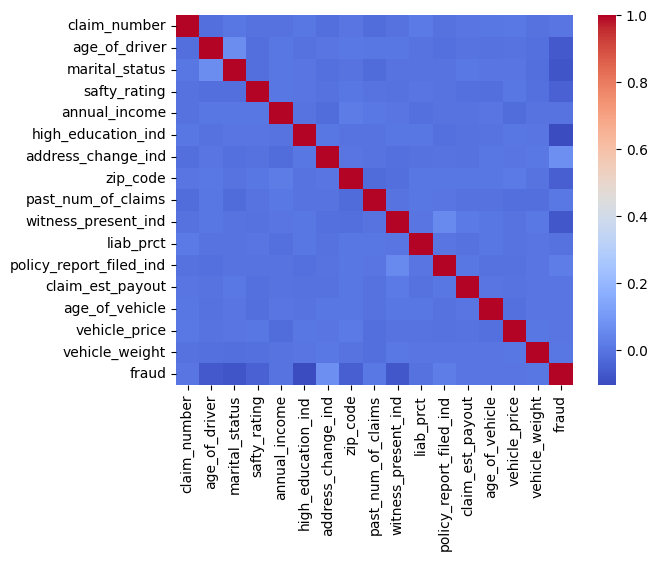

In [61]:
corr = df_train.select_dtypes(include='number').corr()
corr_target = corr['fraud'].sort_values(ascending=False)
print(corr_target)
sns.heatmap(corr, cmap='coolwarm')

<Axes: xlabel='age_of_driver'>

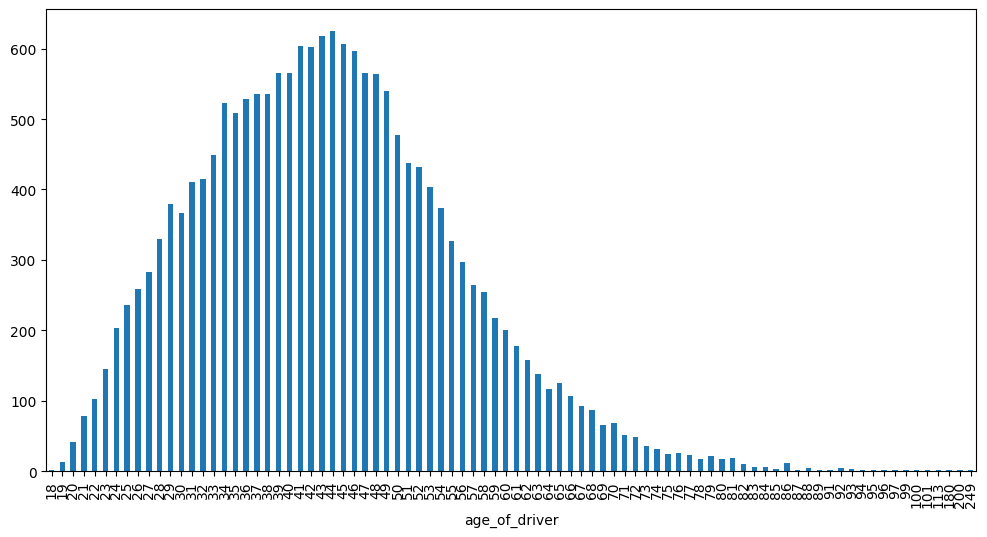

In [62]:
df_train['age_of_driver'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))

# Pré-processamento

In [63]:
df_train.isna().sum()

claim_number                 0
age_of_driver                0
gender                       0
marital_status               2
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout             0
age_of_vehicle               0
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

In [64]:
df_test.isna().sum()

claim_number                0
age_of_driver               0
gender                      0
marital_status              5
safty_rating                0
annual_income               0
high_education_ind          0
address_change_ind          0
living_status               0
zip_code                    0
claim_date                  0
claim_day_of_week           0
accident_site               0
past_num_of_claims          0
witness_present_ind        88
liab_prct                   0
channel                     0
policy_report_filed_ind     0
claim_est_payout            0
age_of_vehicle              0
vehicle_category            0
vehicle_price               0
vehicle_color               0
vehicle_weight              0
dtype: int64

In [65]:
df_train['marital_status'] = df_train['marital_status'].fillna(df_train['marital_status'].median())
df_train['witness_present_ind'] = df_train['witness_present_ind'].fillna(df_train['witness_present_ind'].median())

In [66]:
df_test['marital_status'] = df_test['marital_status'].fillna(df_test['marital_status'].median())
df_test['witness_present_ind'] = df_test['witness_present_ind'].fillna(df_test['witness_present_ind'].median())

In [67]:
df_train.loc[(df_train["age_of_driver"] > 110) | (df_train["age_of_driver"] < 0), "age_of_driver"] = df_train["age_of_driver"].median()

In [68]:
df_test.loc[(df_test["age_of_driver"] > 110) | (df_test["age_of_driver"] < 0), "age_of_driver"] = df_test["age_of_driver"].median()

In [69]:
num_features = df_train.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df_train[num_features] = scaler.fit_transform(df_train[num_features])
df_train.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,0.091939,0.481928,M,1.0,0.828283,0.917054,1.0,0.0,Own,0.999342,...,0.88,Broker,0.0,0.000000,0.157895,Medium,0.348408,other,0.158129,0.0
1,0.377925,0.228916,F,0.0,0.757576,0.294068,1.0,0.0,Rent,0.999071,...,0.02,Broker,1.0,0.000000,0.000000,Large,0.129892,blue,0.166881,0.0
2,0.771685,0.180723,F,0.0,0.818182,0.516035,1.0,0.0,Rent,0.999342,...,0.95,Broker,1.0,0.000000,0.000000,Compact,0.000000,black,0.068435,0.0
3,0.634676,0.301205,F,0.0,0.393939,0.721525,1.0,0.0,Own,0.176628,...,1.00,Broker,0.0,0.039556,0.000000,Large,0.677107,white,0.157463,1.0
4,0.360091,0.301205,F,1.0,0.838384,0.343279,1.0,1.0,Own,0.236804,...,0.58,Broker,0.0,0.156985,0.000000,Medium,0.513667,blue,0.378100,0.0


In [70]:
num_features = df_test.select_dtypes(include=['int64', 'float64']).columns
num_features = [c for c in num_features if c != 'claim_number']
scaler = MinMaxScaler()
df_test[num_features] = scaler.fit_transform(df_test[num_features])
df_test.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,2309,0.243902,M,1.0,0.868687,0.278743,1.0,1.0,Own,0.176439,...,0.0,0.64,Broker,0.0,0.198427,0.000000,Compact,0.000000,gray,0.356428
1,22405,0.304878,M,1.0,0.969697,0.867761,0.0,0.0,Own,0.999929,...,0.0,0.81,Broker,1.0,0.166195,0.368421,Medium,0.000000,other,0.075039
2,23398,0.378049,M,1.0,0.747475,0.342215,1.0,0.0,Own,0.236616,...,0.0,0.94,Broker,1.0,0.000000,0.000000,Compact,0.416212,gray,0.128456
3,25059,0.451220,M,1.0,0.696970,0.698622,1.0,1.0,Rent,0.999812,...,0.0,0.47,Broker,0.0,0.108446,0.684211,Large,0.000000,red,0.038067
4,2665,0.048780,M,1.0,0.878788,0.579416,0.0,1.0,Rent,0.999859,...,0.0,0.93,Online,1.0,0.275419,0.000000,Medium,0.000000,other,0.176907


In [71]:
cat_features = df_train.select_dtypes(include=['object', 'category']).columns
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded = enc.fit_transform(df_train[cat_features])

encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_features))

df_train = pd.concat([df_train.drop(columns=cat_features), encoded_df], axis=1)
df_train.head()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white
0,0.091939,0.481928,1.0,0.828283,0.917054,1.0,0.0,0.999342,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.377925,0.228916,0.0,0.757576,0.294068,1.0,0.0,0.999071,0.325581,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.771685,0.180723,0.0,0.818182,0.516035,1.0,0.0,0.999342,0.000000,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.634676,0.301205,0.0,0.393939,0.721525,1.0,0.0,0.176628,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.360091,0.301205,1.0,0.838384,0.343279,1.0,1.0,0.236804,0.209302,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [72]:
cat_features = df_test.select_dtypes(include=['object', 'category']).columns
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded = enc.fit_transform(df_test[cat_features])

encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_features))

df_test = pd.concat([df_test.drop(columns=cat_features), encoded_df], axis=1)
df_train.head()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white
0,0.091939,0.481928,1.0,0.828283,0.917054,1.0,0.0,0.999342,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.377925,0.228916,0.0,0.757576,0.294068,1.0,0.0,0.999071,0.325581,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.771685,0.180723,0.0,0.818182,0.516035,1.0,0.0,0.999342,0.000000,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.634676,0.301205,0.0,0.393939,0.721525,1.0,0.0,0.176628,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.360091,0.301205,1.0,0.838384,0.343279,1.0,1.0,0.236804,0.209302,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [73]:
X = df_train.drop(columns=['claim_number', 'fraud'])
Y = df_train['fraud']

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

X_test_pca = pca.transform(df_test.drop(columns=['claim_number']))

In [74]:
X_train, X_val, y_train, y_val = train_test_split(
    X_reduced,
    Y,
    test_size=0.15,
    random_state=42,
    stratify=df_train['fraud']
)

In [75]:
X_train_t = torch.tensor(np.asarray(X_train), dtype=torch.float32)
y_train_t = torch.tensor(np.asarray(y_train).reshape(-1, 1), dtype=torch.float32)
X_val_t   = torch.tensor(np.asarray(X_val), dtype=torch.float32)
y_val_t   = torch.tensor(np.asarray(y_val).reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)

# MLP

In [76]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [77]:
mlp = MLP(input_dim=X_train.shape[1])

loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

In [78]:
train_losses, val_losses = [], []

max_epochs = 500
patience = 15        
min_delta = 1e-3     

best_val_loss = float("inf")
epochs_no_improve = 0
best_state_dict = None
warmup_epochs = 20

for epoch in range(max_epochs):
    mlp.train()
    train_epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp(xb)
        loss = loss_function(preds, yb)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    train_losses.append(train_epoch_loss / len(train_loader))

    mlp.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = mlp(xb)
            loss = loss_function(preds, yb)
            val_epoch_loss += loss.item()
    val_losses.append(val_epoch_loss / len(val_loader))

    cur_val = val_losses[-1]
    improved = False

    if epoch > warmup_epochs:
        if cur_val < best_val_loss - min_delta:
            best_val_loss = cur_val
            best_state_dict = mlp.state_dict().copy()
            epochs_no_improve = 0
            improved = True
        else:
            epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {cur_val:.6f} | improved: {improved} | patience: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"Early stopping: sem melhora por {patience} épocas. Melhor val_loss = {best_val_loss:.6f}")
        break

if best_state_dict is not None:
    mlp.load_state_dict(best_state_dict)
    print("Melhor modelo restaurado ao final do treinamento.")
else:
    print("Nenhuma melhora observada — mantendo último estado do modelo.")


Epoch 1/500 | Train Loss: 0.608775 | Val Loss: 0.508453 | improved: False | patience: 0/15
Epoch 2/500 | Train Loss: 0.480693 | Val Loss: 0.452183 | improved: False | patience: 0/15
Epoch 3/500 | Train Loss: 0.439426 | Val Loss: 0.436364 | improved: False | patience: 0/15
Epoch 4/500 | Train Loss: 0.423300 | Val Loss: 0.428721 | improved: False | patience: 0/15
Epoch 5/500 | Train Loss: 0.415616 | Val Loss: 0.426524 | improved: False | patience: 0/15
Epoch 6/500 | Train Loss: 0.411020 | Val Loss: 0.425044 | improved: False | patience: 0/15
Epoch 7/500 | Train Loss: 0.408441 | Val Loss: 0.421636 | improved: False | patience: 0/15
Epoch 8/500 | Train Loss: 0.406895 | Val Loss: 0.420637 | improved: False | patience: 0/15
Epoch 9/500 | Train Loss: 0.405339 | Val Loss: 0.419050 | improved: False | patience: 0/15
Epoch 10/500 | Train Loss: 0.406488 | Val Loss: 0.420457 | improved: False | patience: 0/15
Epoch 11/500 | Train Loss: 0.406090 | Val Loss: 0.420570 | improved: False | patience: 0/

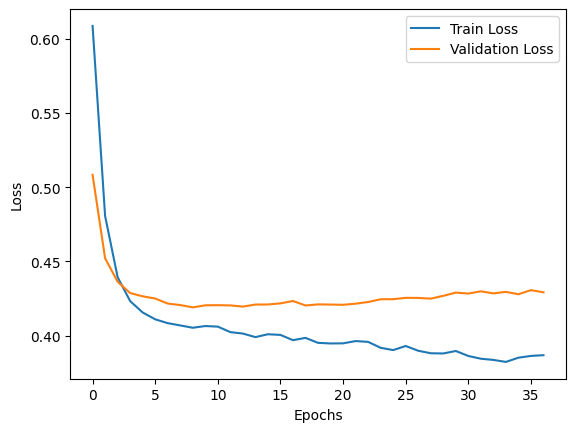

In [79]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
mlp.cpu()
mlp.eval()

probs_list = []
with torch.no_grad():
    for xb, _ in val_loader:
        out = mlp(xb)
        probs_list.append(out.numpy())

probs = np.vstack(probs_list).ravel()

if hasattr(y_val, "values"):
    y_val_np = y_val.values.ravel().astype(int)
else:
    y_val_np = np.array(y_val).ravel().astype(int)


best_t, best_f1 = 0.5, -1.0
best_preds = None
for t in np.linspace(0.01, 0.99, 99):
    preds_t = (probs >= t).astype(int)
    f1 = f1_score(y_val_np, preds_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
        best_preds = preds_t

print("Best threshold on val:", best_t, "Best F1:", best_f1)

acc  = accuracy_score(y_val_np, best_preds)
prec = precision_score(y_val_np, best_preds, zero_division=0)
rec  = recall_score(y_val_np, best_preds, zero_division=0)
f1   = f1_score(y_val_np, best_preds, zero_division=0)
cm   = confusion_matrix(y_val_np, best_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print("Confusion matrix:\n", cm)

Best threshold on val: 0.17 Best F1: 0.3561470215462611
Accuracy: 0.6237
Precision: 0.2441
Recall: 0.6581
F1: 0.3561
Confusion matrix:
 [[1403  870]
 [ 146  281]]


In [81]:
mlp.cpu()
mlp.eval()

X_test_t = torch.tensor(X_test_pca, dtype=torch.float32)

with torch.no_grad():
    out = mlp(X_test_t)
    probs = out.numpy().ravel()

preds = (probs >= best_t).astype(int)

submission = pd.DataFrame({
    'claim_number': df_test['claim_number'],
    'fraud': preds
})

submission.to_csv('submission.csv', index=False)